In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/nshokran/projects/utilities/")
sys.path.append("/home/nshokran/projects/Hi-C-embedding/GraphEmbedding")
import utils
from ge.models import deepwalk, line, sdne
import networkx as nx

2021-12-01 11:46:05.679948: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nshokran/gsl/lib
2021-12-01 11:46:05.680006: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<module 'numpy' from '/home/nshokran/miniconda3/envs/embedding/lib/python3.7/site-packages/numpy/__init__.py'>

In [3]:
contact_matrices = {}
for chr1 in np.arange(21,23):
    for chr2 in np.arange(chr1,23):
        contact_matrices[chr1,chr2] = utils.create_hic_mat('GM12878',chr1,chr2,100000,'oe')

In [26]:
contact_lists = pd.DataFrame(columns = ['source', 'target', 'weight'])
for chr1 in np.arange(21,23):
    for chr2 in np.arange(chr1,23):
        contact_lists = pd.concat([contact_lists,utils.create_hic_list('GM12878',chr1,chr2,100000,'oe')[0]])
contact_lists['weight'] = np.arcsinh(contact_lists['weight'])
contact_lists.sort_values(['source','target'], inplace = True)
loops = contact_lists[contact_lists['source']==contact_lists['target']]
non_loops = contact_lists[contact_lists['source']!=contact_lists['target']]
reverse_non_loops = non_loops[['target','source','weight']]
reverse_non_loops.columns = ['source','target','weight']
sym_non_loops = pd.concat([non_loops,reverse_non_loops])
sym_non_loops.sort_values(['source','target'], inplace = True)
full_contact_lists = pd.concat([loops,sym_non_loops])
full_contact_lists.sort_values(['source','target'], inplace = True)
non_loops.to_csv("unidirectional.txt", sep = "\t", header = None, index = False)
sym_non_loops.to_csv("bidirectional.txt", sep = "\t", header = None, index = False)
full_contact_lists.to_csv("bidirectional_loops.txt", sep = "\t", header = None, index = False)

In [2]:
uni_G = nx.read_edgelist('unidirectional.txt',create_using=nx.DiGraph(),delimiter = "\t",
                         nodetype = int, data=(("weight", float),))#read graph
'''
bi_G = nx.read_edgelist('bidirectional.txt',create_using=nx.DiGraph(),delimiter = "\t",
                         nodetype = int, data=(("weight", float),))#read graph
bi_loop_G = nx.read_edgelist('bidirectional_loops.txt',create_using=nx.DiGraph(),delimiter = "\t",
                         nodetype = int, data=(("weight", float),))#read graph
'''

'\nbi_G = nx.read_edgelist(\'bidirectional.txt\',create_using=nx.DiGraph(),delimiter = "\t",\n                         nodetype = int, data=(("weight", float),))#read graph\nbi_loop_G = nx.read_edgelist(\'bidirectional_loops.txt\',create_using=nx.DiGraph(),delimiter = "\t",\n                         nodetype = int, data=(("weight", float),))#read graph\n'

In [ ]:
###LINE###
model = line.LINE(uni_G,embedding_size=128,order='second') #init model,order can be ['first','second','all']
model.train(batch_size=1024,epochs=50,verbose=2)# train model
embeddings = model.get_embeddings()# get embedding vectors

In [7]:
def make_embedding_df(embeddings_dict, dim):
    embeddings_df = []
    for key in embeddings_dict.keys():
        emb_dict = {'node': key}
        for e, emb in enumerate(embeddings_dict[key]):
            emb_dict['emb'+str(e+1)] = emb
        embeddings_df.append(emb_dict)
    embeddings_df = pd.DataFrame(embeddings_df)
    return embeddings_df

In [ ]:
###here the batch size is greater than node size however in genome wide...
sdne_model = sdne.SDNE(uni_G,hidden_size=[256,128]) #init model
#sdne_model.train(batch_size=100,epochs=40,verbose=2)# train model
#sdne_embeddings = sdne_model.get_embeddings()# get embedding vectors

/home/nshokran/miniconda3/envs/embedding/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nshokran/miniconda3/envs/embedding/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nshokran/miniconda3/envs/embedding/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

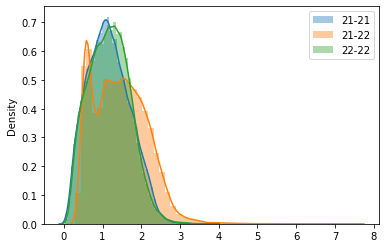

In [26]:
chr1 = 21
chr2 = 22
sns.distplot(np.arcsinh(contact_matrices[chr1,chr1][contact_matrices[chr1,chr1]!=0]), label = str(chr1) + "-" + str(chr1))
sns.distplot(np.arcsinh(contact_matrices[chr1,chr2][contact_matrices[chr1,chr2]!=0]), label = str(chr1) + "-" + str(chr2))
sns.distplot(np.arcsinh(contact_matrices[chr2,chr2][contact_matrices[chr2,chr2]!=0]), label = str(chr2) + "-" + str(chr2))
plt.legend()
plt.show()